
# **Moments, Sorting, Approximating & Matching Contours**

#### **Iremos aprender:**
1. Ordenar contornos sobre a área.
2. Ordenar da esquerda para a direita (Bom para operações em OCR) 
3. Contornos aproximados 
4. Convex Hull

In [1]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Download and unzip our images
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/images.zip
!unzip -qq images.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


### **Encontrando contornos normalmente**

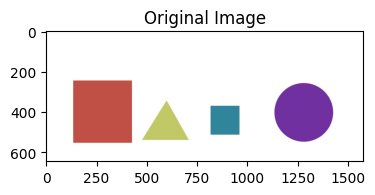

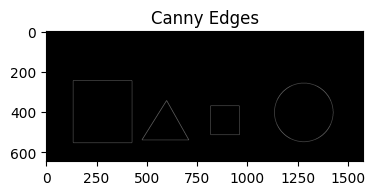

Number of contours found =  4


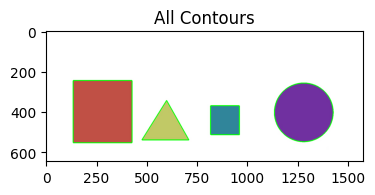

In [2]:
# Carregando imagem
image = cv2.imread('images/bunchofshapes.jpg')
imshow('Original Image', image)

# Imagem em escala de cinza
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# Encontrando Canny edges
edged = cv2.Canny(gray, 50, 200)
imshow('Canny Edges', edged)

# Pegando os contornos externos, pois nossos objetos não possuem aninhamento 
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Number of contours found = ", len(contours))

# Draw all contours over blank image
cv2.drawContours(image, contours, -1, (0,255,0), 3)
imshow('All Contours', image)

## **Ordenando por área usando cv2.ContourArea e cv2.Moments**

Moments são um conjunto de escalonadores que são um agregado de um conjunto de vetores.
São usados na mecanica e estatística frequentemente e foram adaptados para a visão computacional.
Sem entrar muito na matemática por trás disso, pense nisso como uma medida de intensidades de imagem. Uma imagem com intensidades de pixel I(x,y), os momentos são dados por:

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/moments.png)

Os momentos são propriedades matemáticas que fornecem informações sobre a distribuição de pixels em uma imagem, como o centro de massa, área, orientação e outros parâmetros úteis.
Os momentos de uma imagem são calculados como uma soma ponderada das coordenadas dos pixels em uma imagem.

A função cv2.moments retorna um dicionário com diversos valores, eles são:

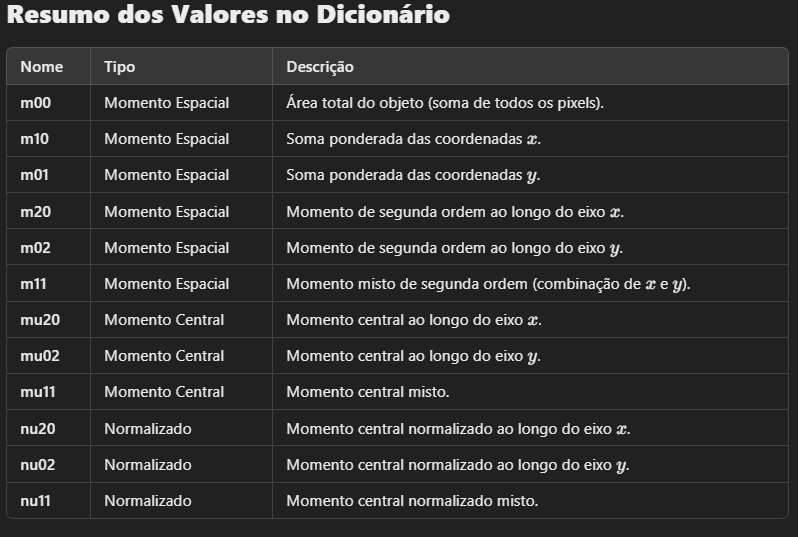

Exemplo de uso: Achar o centroide.

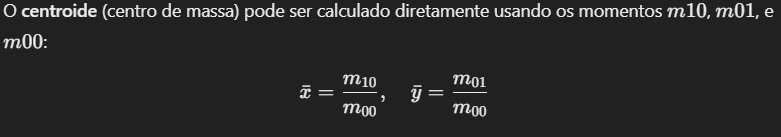

Contor Areas before sorting...
[20587.5, 22901.5, 66579.5, 90222.0]
Contor Areas after sorting...
[90222.0, 66579.5, 22901.5, 20587.5]
Vendo os momentos do contorno chave 0
{'m00': 90222.0, 'm10': 25262160.0, 'm01': 36043689.0, 'm20': 7714377697.0, 'm11': 10092232920.0, 'm02': 15117233610.0, 'm30': 2518970577480.0, 'm21': 3081893889951.5, 'm12': 4232825410800.0, 'm03': 6612840930940.5, 'mu20': 640972897.0, 'mu11': 0.0, 'mu02': 717779854.5, 'mu30': 0.0, 'mu21': 0.0, 'mu12': 0.0, 'mu03': 0.0, 'nu20': 0.07874350932988444, 'nu11': 0.0, 'nu02': 0.08817924273266713, 'nu30': 0.0, 'nu21': 0.0, 'nu12': 0.0, 'nu03': 0.0}
Vendo os momentos do contorno chave 1
{'m00': 66579.5, 'm10': 85028799.16666666, 'm01': 26845687.166666664, 'm20': 108943070556.91666, 'm11': 34284686431.958332, 'm02': 11177394386.916666, 'm30': 140032111521960.56, 'm21': 43927230338982.85, 'm12': 14274669053677.85, 'm03': 4791441150778.55, 'mu20': 352638250.7964325, 'mu11': 11080.150943756104, 'mu02': 352877539.38054466, 'mu30

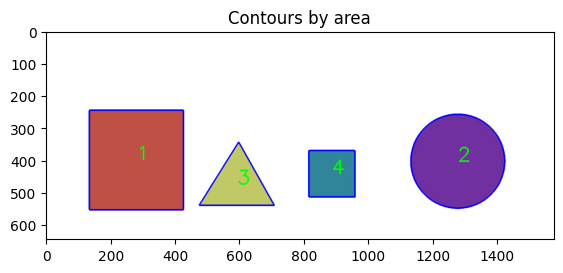

In [ ]:
import cv2
import numpy as np

# Função para pegar o contorno da area
def get_contour_areas(contours):
    """returns the areas of all contours as list"""
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return all_areas

# carregando a imagem
image = cv2.imread('images/bunchofshapes.jpg')

# Mostrando os contornos antes de ordenar
print("Contor Areas before sorting...")
print(get_contour_areas(contours))

# Ordenando do maior pro menor
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

print("Contor Areas after sorting...") 
print(get_contour_areas(sorted_contours))

# Desenhando os contornos ordenados e indexados
for (i,c) in enumerate(sorted_contours):
    M = cv2.moments(c) #Calculando os momentos com os valores do contorno
    print(f'Vendo os momentos do contorno chave {i}')
    print(M)
    #Obtendo o centroide
    cx = int(M['m10'] / M['m00']) 
    cy = int(M['m01'] / M['m00'])
    cv2.putText(image, str(i+1), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3) #Escrevendo no centro do objeto
    cv2.drawContours(image, [c], -1, (255,0,0), 3)

imshow('Contours by area', image)

#### **Criando funções estratégicas baseadas em contornos e moments**

In [3]:
# Funções que usaremos para ordenar por posição
def x_cord_contour(contours):
    """Retorna a coordenada X para o centróide do contorno"""
    if cv2.contourArea(contours) > 10:
        M = cv2.moments(contours)
        return (int(M['m10']/M['m00']))
    else:
        pass
    
def label_contour_center(image, c):
    """Coloca um círculo vermelho nos centros dos contornos"""
    M = cv2.moments(c)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    
    # Draw the countour number on the image
    cv2.circle(image,(cx,cy), 10, (0,0,255), -1)
    return image

#### **Usamos Momentos para calcular o centro e depois usamos a coordenada X para ordenar da esquerda para a direita**

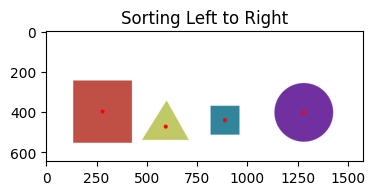

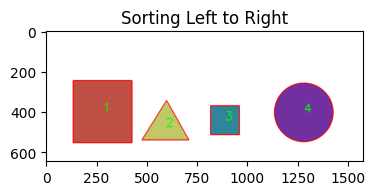

In [5]:
#ORDENANDO DA ESQUERDA PARA A DIREITA DE DUAS FORMAS

# 1 FORMA
# Load our image
image = cv2.imread('images/bunchofshapes.jpg')
orginal_image = image.copy()

# Computer Center of Mass or centroids and draw them on our image
for (i, c) in enumerate(contours):
    orig = label_contour_center(image, c)
 
# Showing the Contour centers
imshow("Sorting Left to Right", image)


# 2 FORMA

# Sort by left to right using our x_cord_contour function
contours_left_to_right = sorted(contours, key = x_cord_contour, reverse = False)

# Labeling Contours left to right
for (i,c)  in enumerate(contours_left_to_right):
    cv2.drawContours(orginal_image, [c], -1, (0,0,255), 3)  
    M = cv2.moments(c)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    cv2.putText(orginal_image, str(i+1), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
    (x, y, w, h) = cv2.boundingRect(c)  

imshow('Sorting Left to Right', orginal_image)

## **Approximating Contours using ApproxPolyDP**

### **Using ApproxPolyDP to approximate contours as a more defined shape**

Ele aproxima uma forma de contorno de outra forma com menos número de vértices dependendo da precisão que especificamos.
A função cv2.approxPolyDP do OpenCV é utilizada para aproximar um contorno por uma polilinha ou um polígono com menos vértices. Ela reduz a quantidade de pontos em um contorno mantendo a forma aproximada do objeto. Isso é muito útil para simplificar contornos complexos, tornando-os mais fáceis de analisar.


***cv2.approxPolyDP(contour, Approximation Accuracy, Closed)***
- **contour** – é o contorno individual que desejamos aproximar
- **Approximation Accuracy** – Parâmetro importante é determinar a precisão da aproximação. Valores pequenos fornecem aproximações precisas, valores grandes fornecem aproximações mais genéricas. Uma boa regra prática é menos de 5% do perímetro do contorno
- **Closed** – um valor booleano que indica se o contorno aproximado deve ser aberto ou fechado


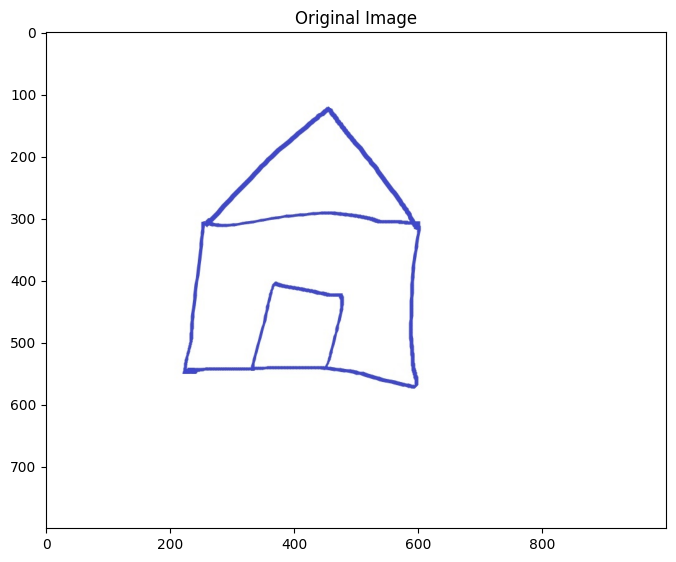

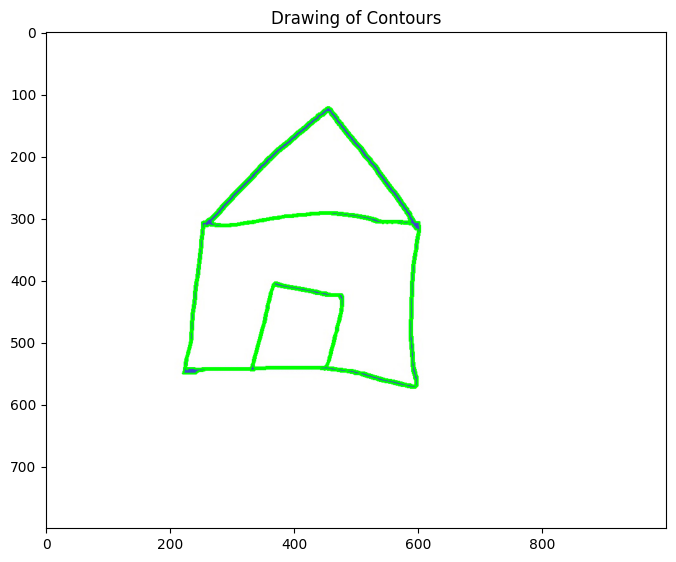

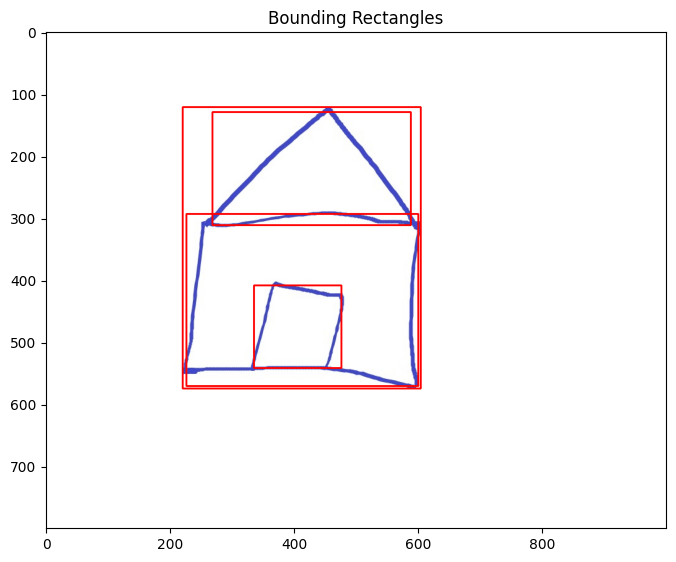

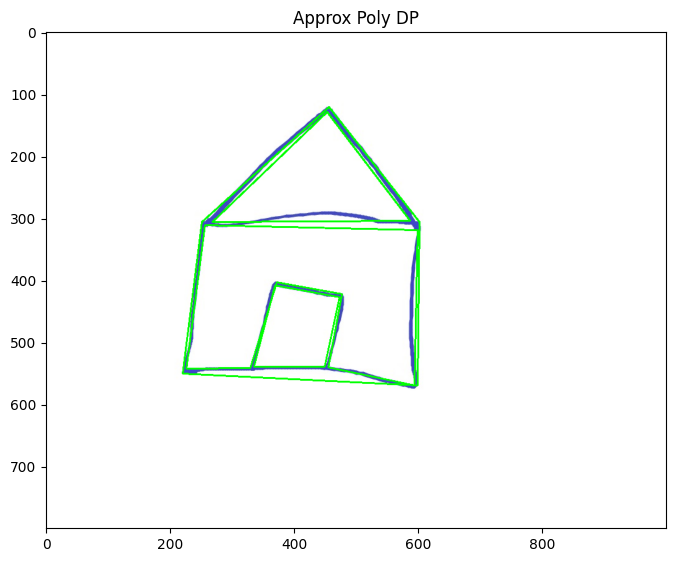

In [45]:
import numpy as np
import cv2

# Load image and keep a copy
image = cv2.imread('images/house.jpg')
orig_image = image.copy()
imshow('Original Image', orig_image)
 
# Grayscale and binarize
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Find contours 
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
copy = image.copy()

# Iterate through each contour 
for c in contours:
    """ 
    A função cv2.boundingRect do OpenCV é utilizada para calcular o menor retângulo 
    delimitador que pode envolver um contorno ou um conjunto de pontos em uma imagem.
    Ela retorna as coordenadas do canto superior esquerdo do retângulo e suas dimensões 
    (largura e altura).
    """
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(orig_image,(x,y),(x+w,y+h),(0,0,255),2)
    cv2.drawContours(image, [c], 0, (0, 255, 0), 2)

imshow('Drawing of Contours', image)
imshow('Bounding Rectangles', orig_image)
# Iterate through each contour and compute the approx contour
for c in contours:
    # Calculate accuracy as a percent of the contour perimeter
    """ 
    A função cv2.arcLength do OpenCV é utilizada para calcular o perímetro de um contorno ou o comprimento de uma curva.
    Ela é frequentemente usada em conjunto com cv2.findContours e cv2.approxPolyDP para análise e simplificação de contornos. 
    """
    accuracy = 0.03 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, accuracy, True)
    cv2.drawContours(copy, [approx], 0, (0, 255, 0), 2)
print(approx)
imshow('Approx Poly DP', copy)

## **Convex Hull**

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/convex.png)

O Convex Hull será semelhante à aproximação de contorno, mas não é (ambos podem fornecer os mesmos resultados em alguns casos).

A função cv2.convexHull() verifica uma curva em busca de defeitos de convexidade e a corrige. De modo geral, curvas convexas são aquelas que estão sempre salientes ou pelo menos planas. E se estiver abaulado por dentro, é chamado de defeito de convexidade. Por exemplo, verifique a imagem da mão abaixo. A linha vermelha mostra o convex hull da mão. 
O duplo-marcas de setas laterais mostram os defeitos de convexidade, que são os desvios máximos locais do casco em relação aos contornos.

O Convex Hull (ou envoltória convexa) é uma técnica geométrica utilizada para encontrar o menor polígono convexo que pode envolver completamente um conjunto de pontos ou um contorno. Em outras palavras, é como se uma "cama elástica" fosse esticada ao redor dos pontos de um contorno, envolvendo-os no menor formato possível, sem "dobras" para dentro.

Teste de convexidade:

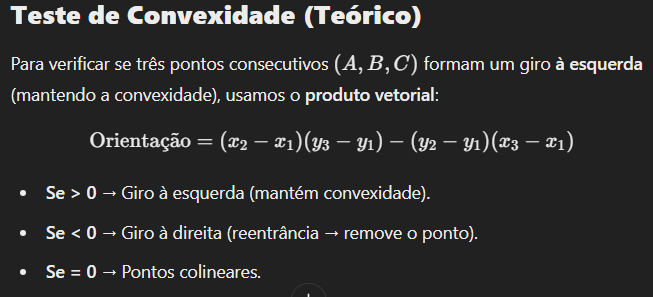

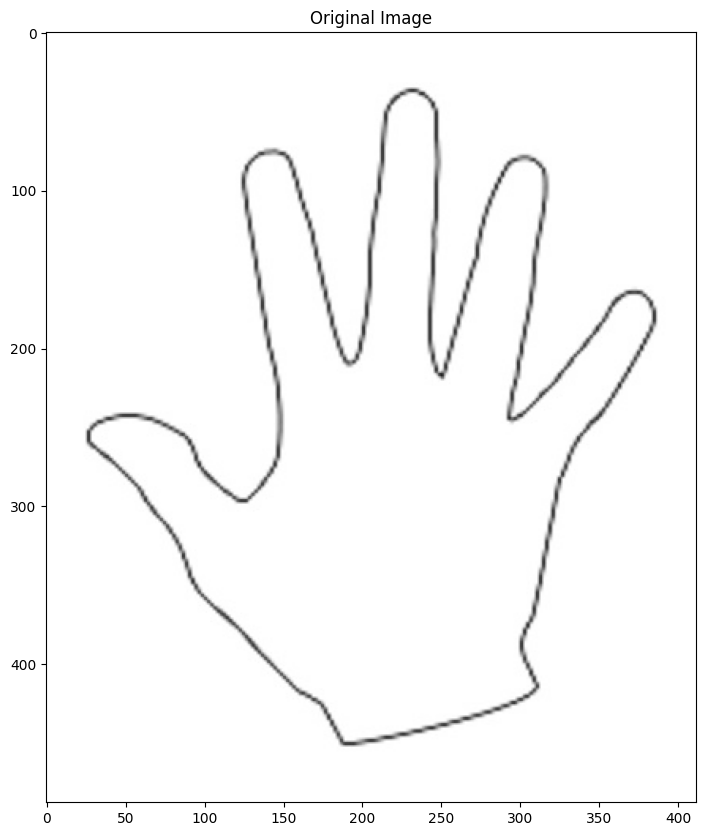

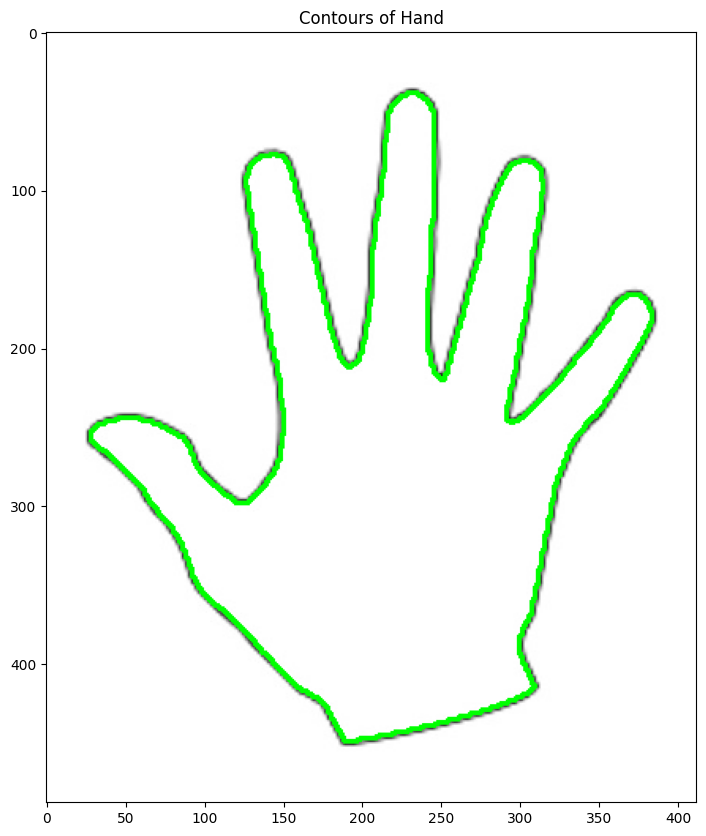

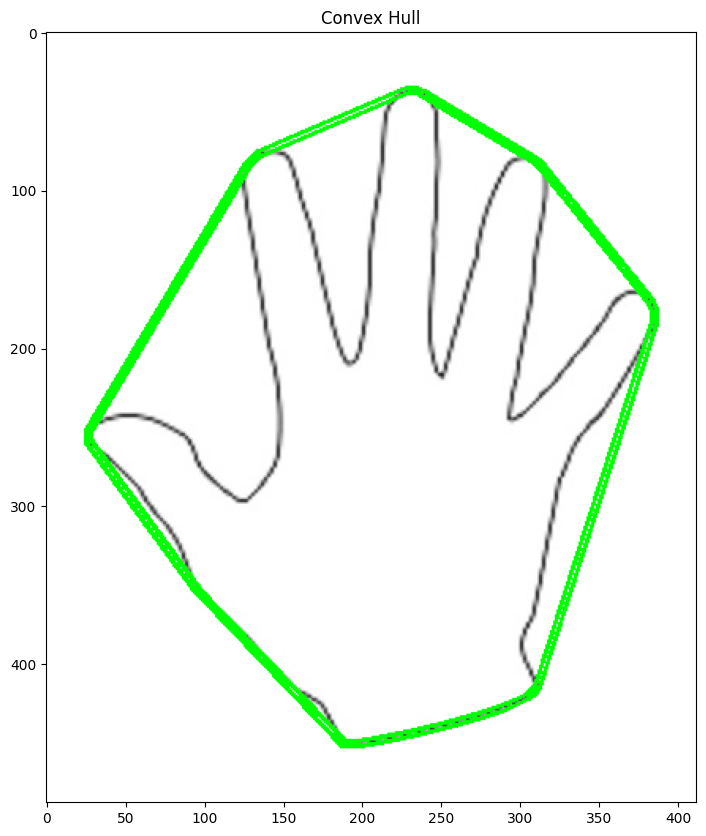

In [6]:
import numpy as np
import cv2

image = cv2.imread('images/hand.jpg')
orginal_image = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

imshow('Original Image', image)

# Threshold the image
ret, thresh = cv2.threshold(gray, 176, 255, 0)

# Find contours 
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(image, contours, 0, (0, 255, 0), 2)
imshow('Contours of Hand', image)


# Sort Contors by area and then remove the largest frame contour
n = len(contours) - 1
contours = sorted(contours, key=cv2.contourArea, reverse=False)[:n]

# Iterate through contours and draw the convex hull
for c in contours:
    hull = cv2.convexHull(c)
    cv2.drawContours(orginal_image, [hull], 0, (0, 255, 0), 2)
    
imshow('Convex Hull', orginal_image)

# **Matching Contours**
#### **cv2.matchShapes(contour template, contour, method, method parameter)**

A função cv2.matchShapes do OpenCV é usada para comparar dois contornos ou formas e determinar o grau de similaridade entre eles. Essa função calcula a diferença entre as formas com base em momentos de Hu (momentos invariantes)

**Output** – match value (lower values means a closer match)

- Contour Template – Este é o nosso contorno de referência que estamos tentando encontrar na nova imagem
- Contour – O contorno individual que estamos verificando
- Method – Type of contour matching (1, 2, 3)
    - 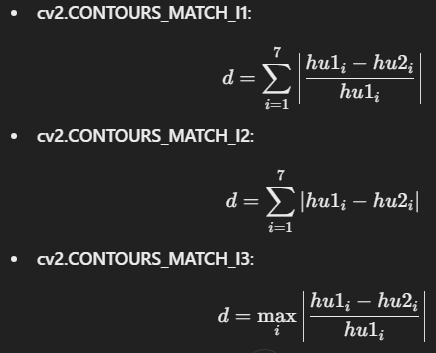 
- Method Parameter – deixe sozinho como 0,0 (não totalmente utilizado em python OpenCV)


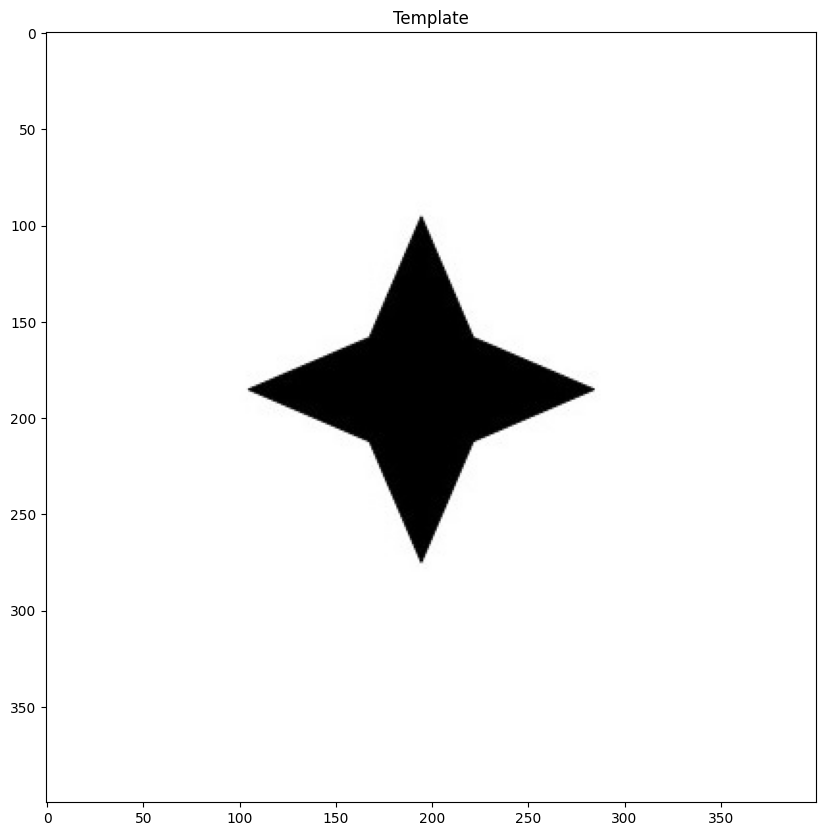

(array([[[  0,   0]],

       [[  0, 399]],

       [[399, 399]],

       [[399,   0]]], dtype=int32), array([[[193,  96]],

       [[194,  95]],

       [[195,  95]],

       [[196,  96]],

       [[196,  97]],

       [[197,  98]],

       [[197, 100]],

       [[198, 101]],

       [[198, 102]],

       [[199, 103]],

       [[199, 104]],

       [[200, 105]],

       [[200, 107]],

       [[201, 108]],

       [[201, 109]],

       [[202, 110]],

       [[202, 111]],

       [[203, 112]],

       [[203, 114]],

       [[204, 115]],

       [[204, 116]],

       [[205, 117]],

       [[205, 118]],

       [[206, 119]],

       [[206, 121]],

       [[207, 122]],

       [[207, 123]],

       [[208, 124]],

       [[208, 125]],

       [[209, 126]],

       [[209, 128]],

       [[210, 129]],

       [[210, 130]],

       [[211, 131]],

       [[211, 132]],

       [[212, 133]],

       [[212, 135]],

       [[213, 136]],

       [[213, 137]],

       [[214, 138]],

       [[214, 139

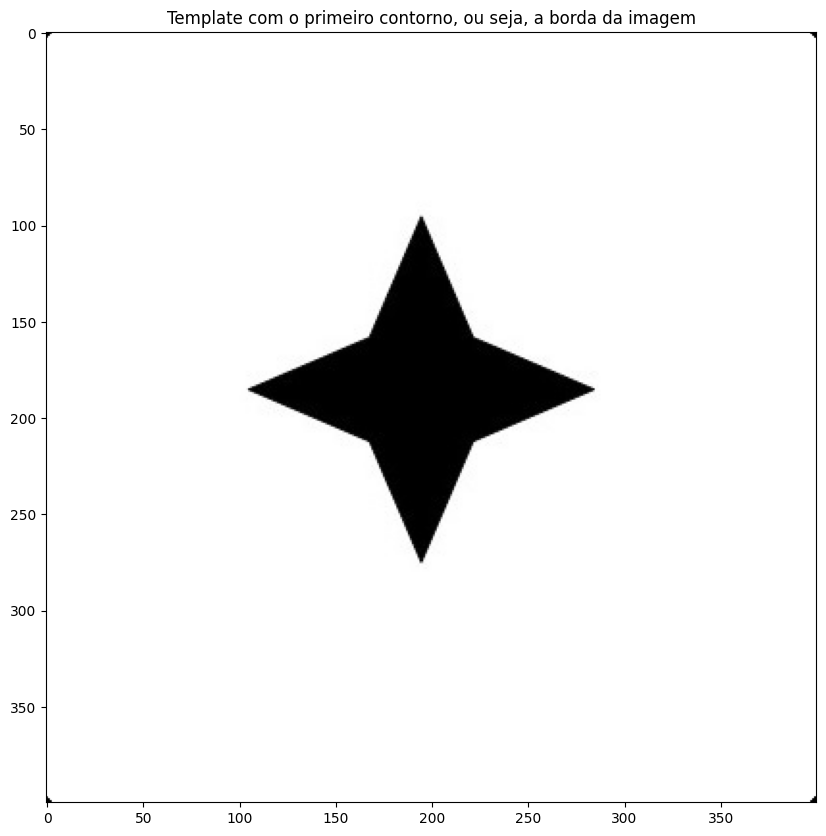

0.13081816783853514
0.1590200533978871
0.1498791568252558
0.07094034474475601


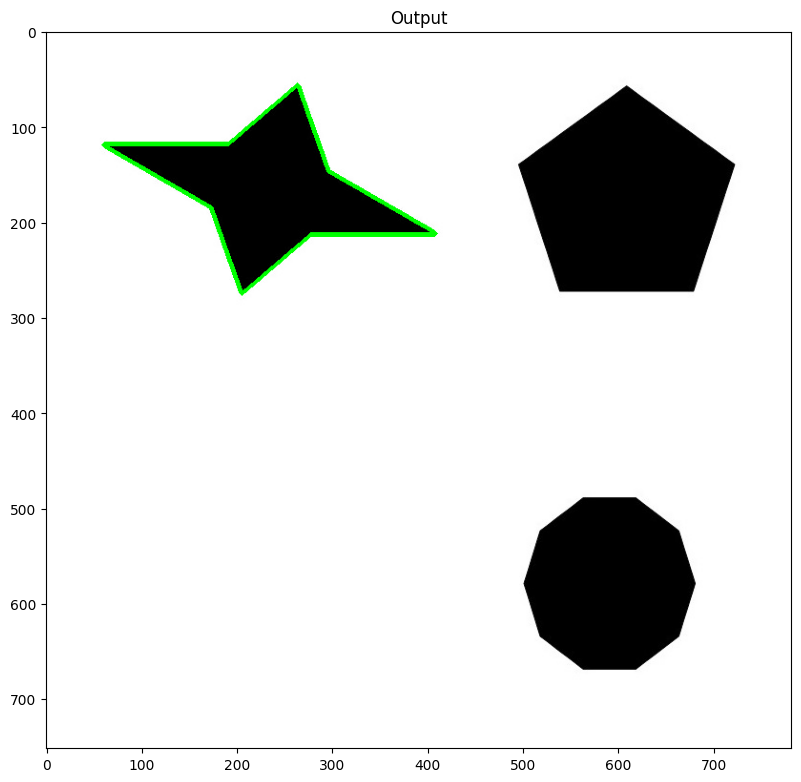

In [12]:
import cv2
import numpy as np

# Load the shape template or reference image
template = cv2.imread('images/4star.jpg',0)
imshow('Template', template)

# carregando a imagem para calcular a similaridade
target = cv2.imread('images/shapestomatch.jpg')
target_gray = cv2.cvtColor(target,cv2.COLOR_BGR2GRAY)

# Vamos usar threshold para ambas antes dos contornos
ret, thresh1 = cv2.threshold(template, 127, 255, 0)
ret, thresh2 = cv2.threshold(target_gray, 127, 255, 0)

# Find contours in template
contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# We need to sort the contours by area so that we can remove the largest
# contour which is the image outline
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

#Vendo a ordem, se mudou
print(contours)
print(f' Sort {sorted_contours}')


#NÃO QUEREMOS A BORDA DA IMAGEM, QUE NORMALMENTE FICA NA PRIMEIRA POSIÇÃO DO ARRAY DE CONTORNOS ORDENADOS E NÃO ORDENADO
cv2.drawContours(template, contours[0], -1, (0,255,0), 3)
imshow('Template com o primeiro contorno, ou seja, a borda da imagem', template)

# NOS QUEREMOS OS CONTORNOS DO OBJETO ESTRELA.
template_contour = contours[1]


# Extraindo os contornos da segunda imagem
contours, hierarchy = cv2.findContours(thresh2, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

closest_contour = 0
for c in contours:
    # Iterate through each contour in the target image and 
    # use cv2.matchShapes to compare contour shapes
    match = cv2.matchShapes(template_contour, c, 3, 0.0)
    print(match)
    # If the match value is less than 0.15 we
    if match < 0.15:
        closest_contour = c
    else:
        closest_contour = []

                
cv2.drawContours(target, [closest_contour], -1, (0,255,0), 3)
imshow('Output', target)